# Analyse modelled fluxes

- Should also compare results of gridded NEE predictions (correlations etc.) with EC point data to see if they follow the same trends. 

In [1]:
import sys
import xarray as xr
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35725,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:36373,Total threads: 16
Dashboard: /proxy/43957/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:39185,


In [3]:
var = 'NEE'
results_name = 'NEE_2003_2021_5km_LGBM.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc'

## Open predictor data

In [11]:
data = xr.open_dataset(data_path,  chunks=dict(x=250,y=250, time=-1))

## Open predictions

In [5]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name,
                       chunks=dict(x=250,y=250, time=-1))#.sel(time=slice('2003','2018'))

## Linear trends

In [ ]:
# import xarray as xr
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

# fill pixels that are all-NaNs
allnans = ds.isnull().all('time').compute()
ds = ds.where(~allnans, other=0)

# regression analysis
delayed_objs = delayed(regression)(ds).persist()

# transforms dask.delayed to dask.array
results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
results = results.compute()
results = results.compute() #need this twice haven't figured out why

# statistical variables definition
variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

# coordination definition
coords = {'y': ds.y, 'x': ds.x}

# output xarray.Dataset definition
ds_out = xr.Dataset(
    data_vars=dict(slope=(["y", "x"], results[0]),
                   intercept=(["y", "x"], results[1]),
                   r_value=(["y", "x"], results[2]),
                   p_value=(["y", "x"], results[3]),
                   std_err=(["y", "x"], results[4]),
                  ),
    coords = coords)

#remask all-NaN pixel
ds_out = ds_out.where(~allnans)
ds_out

### Mask with Evergreen Trees

In [ ]:
lc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/Landcover_merged_5km.nc').isel(time=1)
lc['latitude'] = lc.latitude.astype('float32')
lc['longitude'] = lc.longitude.astype('float32')
lc = lc.rename({'latitude':'y','longitude':'x'})

trees = lc.PFT == 10

In [ ]:
trees.plot.imshow()

In [ ]:
ds_out.slope.max()

In [ ]:
# import folium
# import odc.geo
# import folium
# from odc.geo.xr import assign_crs

# # Create folium Map (ipyleaflet is also supported)
# m = folium.Map(tiles='openstreetmap')

# # Plot each sample image with different colormap
# ds_out.slope.where(trees).odc.add_to(m, cmap='BrBG', vmax=0.2,vmin=-0.2, opacity=1.0)

# # Zoom map to Australia
# m.fit_bounds(ds_out.odc.map_bounds())

# # tile = folium.TileLayer(
# #         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
# #         attr = 'Esri',
# #         name = 'Esri Satellite',
# #         overlay = True,
# #         control = True
# #        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)


# ds_out.slope.where(trees).plot.imshow(size=10, robust=True, cmap='BrBG')
# plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

In [ ]:
ds_out.slope.where(trees).plot.imshow(size=10, robust=True, cmap='BrBG')
plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

In [ ]:
ds_out.slope.plot.imshow(size=10, robust=True, cmap='BrBG')
plt.title('Linear Trend in Evergreen Forest GPP 2003-2018');

## Correlations

TODO: compute p-values and plot hashes over areas with significance > 0.05
https://xskillscore.readthedocs.io/en/stable/api/xskillscore.pearson_r_eff_p_value.html

In [6]:
ds_clim_mean = ds.groupby('time.month').mean()
ds_anom = (ds.groupby('time.month') - ds_clim_mean).compute()

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


In [9]:
ds_anom.chunk({'x':250,'y':250, 'time':-1})

<xarray.DataArray 'NEE' (time: 228, y: 680, x: 840)>
dask.array<xarray-<this-array>, shape=(228, 680, 840), dtype=float32, chunksize=(228, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float32 112.0 112.1 112.1 112.2 ... 153.8 153.9 153.9 154.0
  * y            (y) float32 -10.02 -10.07 -10.12 ... -43.88 -43.92 -43.97
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2021-12-15
    month        (time) int64 dask.array<chunksize=(228,), meta=np.ndarray>

In [19]:
data.data_vars

Data variables:
    kNDVI_anom       (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    FPAR             (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    LST              (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    tree_cover       (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    nontree_cover    (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    nonveg_cover     (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    LST-Tair         (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    TWI              (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    NDWI             (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    rain_anom        (time, y, x) float32 dask.array<chunksize=(228, 250, 250), meta=np.ndarray>
    rain_cml3_

### Rainfall correlations

In [20]:
precip_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['rain_anom'], dim='time').compute()
precip_3_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['rain_cml3_anom'], dim='time').compute()
precip_6_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['rain_cml6_anom'], dim='time').compute()
precip_12_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['rain_cml12_anom'], dim='time').compute()

### Other climate var correlations

In [13]:
vpd_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['vpd'], dim='time').compute()
srad_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['srad_anom'], dim='time').compute()
tavg_corr = xr.corr(ds_anom.chunk({'x':250,'y':250, 'time':-1}), data['tavg_anom'], dim='time').compute()

### Plot correlations of instantenous climate correlations

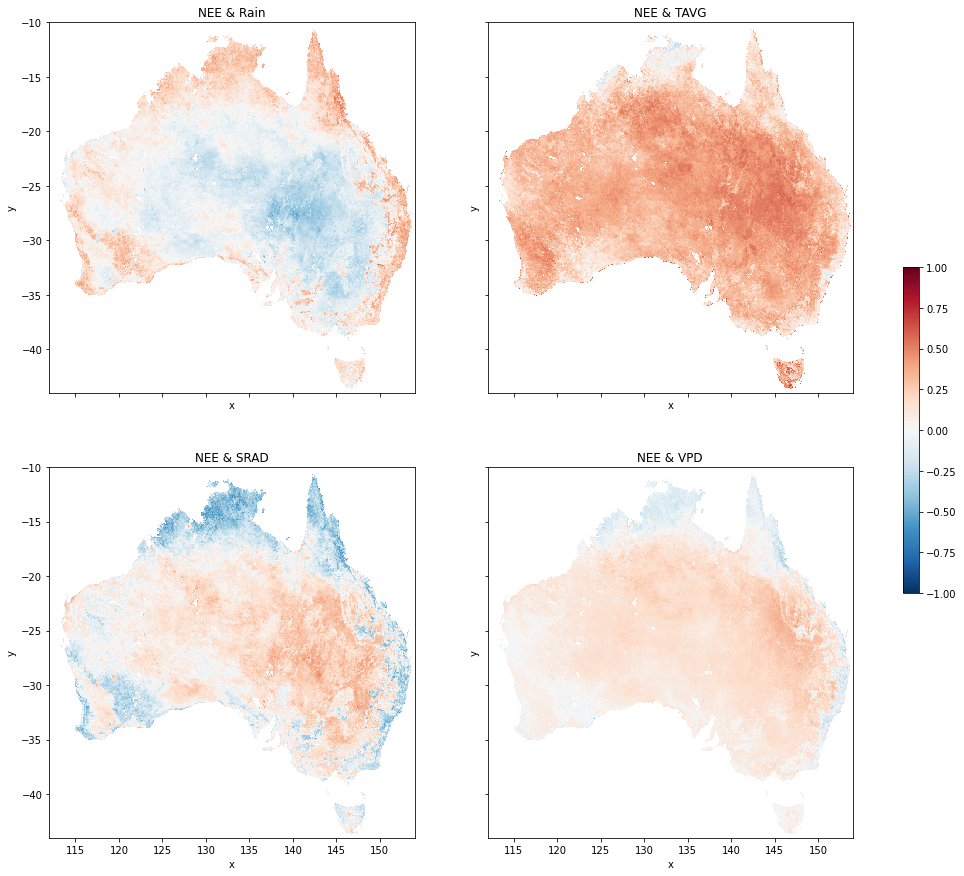

In [29]:
fig,ax = plt.subplots(2,2, figsize=(18,15), sharey=True, sharex=True)
precip_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,0], add_colorbar=False)
ax[0,0].set_title(var+' & Rain');

tavg_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,1], add_colorbar=False)
ax[0,1].set_title(var+' & TAVG');

srad_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[1,0], add_colorbar=False)
ax[1,0].set_title(var+' & SRAD');

im = vpd_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[1,1], add_colorbar=False)
ax[1,1].set_title(var+' & VPD')

cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='vertical', shrink=0.4);
# plt.tight_layout()

### Plot correlations of lagged rainfall correlations

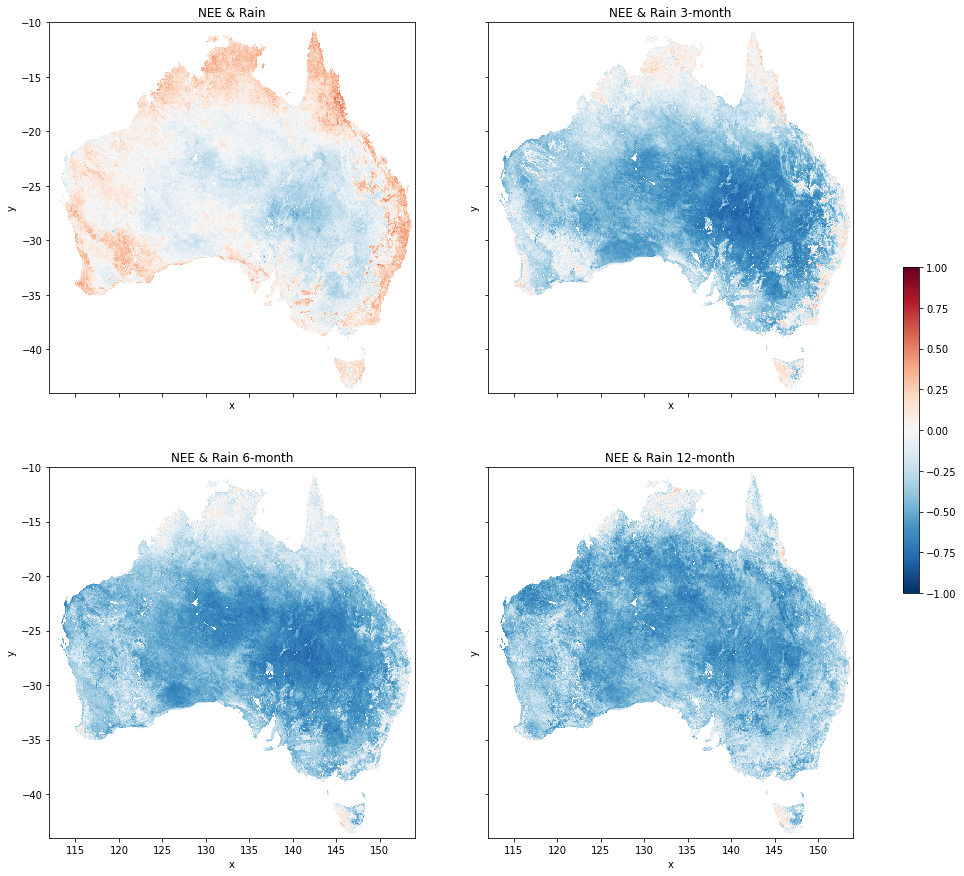

In [30]:
fig,ax = plt.subplots(2,2, figsize=(18,15), sharey=True, sharex=True)
precip_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,0], add_colorbar=False)
ax[0,0].set_title(var+' & Rain');

precip_3_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,1], add_colorbar=False)
ax[0,1].set_title(var+' & Rain 3-month');

precip_6_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[1,0], add_colorbar=False)
ax[1,0].set_title(var+' & Rain 6-month');

im = precip_12_corr.plot.imshow(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[1,1], add_colorbar=False)
ax[1,1].set_title(var+' & Rain 12-month')

cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='vertical', shrink=0.4);
# plt.tight_layout()

### Variable with highest correlation

In [15]:
corrs = xr.merge([
    np.abs(precip_corr.rename('precip_anom')),
    np.abs(vpd_corr.rename('vpd')),
    np.abs(srad_corr.rename('srad_anom')),
    np.abs(tavg_corr.rename('tavg_anom'))
])

max_corrs = corrs.to_array("variable").idxmax("variable")

max_corrs = xr.where(max_corrs == 'precip_anom', 1, max_corrs)
max_corrs = xr.where(max_corrs == 'vpd', 2, max_corrs)
max_corrs = xr.where(max_corrs == 'srad_anom', 3, max_corrs)
max_corrs = xr.where(max_corrs == 'tavg_anom', 4, max_corrs)

max_corrs = max_corrs.astype(np.float32)

In [23]:
rain_corrs = xr.merge([
    np.abs(precip_corr.rename('precip_anom')),
    np.abs(precip_3_corr.rename('precip_3_anom')),
    np.abs(precip_6_corr.rename('precip_6_anom')),
    np.abs(precip_12_corr.rename('precip_12_anom'))
])

rain_max_corrs = rain_corrs.to_array("variable").idxmax("variable")

rain_max_corrs = xr.where(rain_max_corrs == 'precip_anom', 1, rain_max_corrs)
rain_max_corrs = xr.where(rain_max_corrs == 'precip_3_anom', 2, rain_max_corrs)
rain_max_corrs = xr.where(rain_max_corrs == 'precip_6_anom', 3, rain_max_corrs)
rain_max_corrs = xr.where(rain_max_corrs == 'precip_12_anom', 4, rain_max_corrs)

rain_max_corrs = rain_max_corrs.astype(np.float32)

### Plots

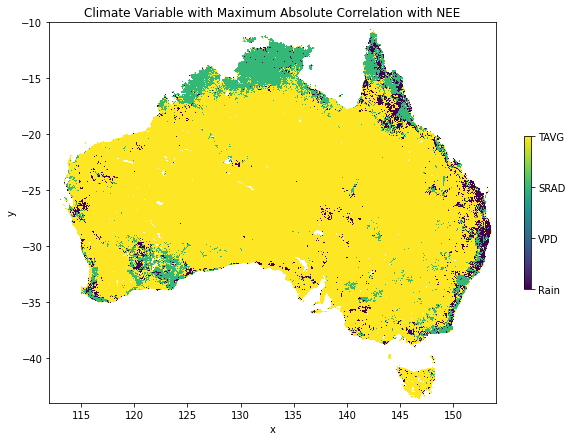

In [28]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
im = max_corrs.plot.imshow(add_colorbar=False, ax=ax)
cbar = fig.colorbar(im, spacing='uniform', ax=ax, orientation='vertical', shrink=0.4)
cbar.set_ticks([1,2,3,4])
cbar.set_ticklabels(['Rain', 'VPD', 'SRAD', 'TAVG'], fontsize=10)
plt.title('Climate Variable with Maximum Absolute Correlation with '+var);

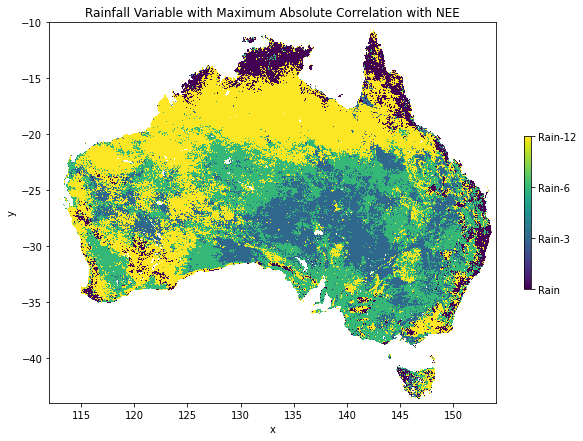

In [27]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
im = rain_max_corrs.plot.imshow(add_colorbar=False, ax=ax)
cbar = fig.colorbar(im, spacing='uniform', ax=ax, orientation='vertical', shrink=0.4)
cbar.set_ticks([1,2,3,4])
cbar.set_ticklabels(['Rain', 'Rain-3', 'Rain-6', 'Rain-12'], fontsize=10)
plt.title('Rainfall Variable with Maximum Absolute Correlation with '+var);

## Plot relationships between NEE, GPP, ER and environmental variables (P, T, SM etc)

Following Lui et al. (2018) 

In [ ]:
gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/GPP_2003_2021_5km_LGBM.nc',
                       chunks=dict(x=250,y=250, time=-1))#.sel(time=slice('2003','2018'))

nee = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021_5km_LGBM.nc',
                       chunks=dict(x=250,y=250, time=-1))#.sel(time=slice('2003','2018'))

In [ ]:
def s_cor(x,y, pthres = 0.05, direction = True):
    """
    Uses the scipy stats module to calculate a Kendall correlation test
    :x vector: Input pixel vector to run tests on
    :y vector: The date input vector
    :pthres: Significance of the underlying test
    :direction: output only direction as output (-1 & 1)
    """
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    if co < 4: # If fewer than 4 observations return -9999
        return np.nan
    # Run the kendalltau test
    r, p_value = stats.spearmanr(x, y, nan_policy='omit')

    # Criterium to return results in case of Significance
    if p_value > pthres:
        return np.nan
    else:
        return r 

def spearman_correlation(x,y,dim='year'):
    return xr.apply_ufunc(
        s_cor, x , y,
        input_core_dims=[[dim], [dim]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32]
        )


In [ ]:
r = spearman_correlation(gpp, nee ,'time').compute()

In [ ]:
r.plot.imshow(size=6, vmin=-1, vmax=1, cmap='RdBu')
plt.title('Signficant (p<0.05) Temporal Spearman Correlations: GPP & NEE')

## Causality

###  Granger casaulity tests?

### Bayesian structure learning?
https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ndvi, variables = ndvi.columns)  